In [ ]:
ffrom google.colab import files
files.upload()  # Upload your kaggle.json file

# Move the kaggle.json file to the appropriate location
!mkdir -p ~/.kaggled
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set proper permissions

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.68G/3.69G [03:00<00:00, 23.4MB/s]
100% 3.69G/3.69G [03:00<00:00, 21.9MB/s]


In [ ]:
!unzip /content/respiratory-sound-database.zip

Archive:  /content/respiratory-sound-database.zip
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respirato

In [ ]:
import os
import math
import wave
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU,ReLU,Flatten,concatenate,Bidirectional,TimeDistributed
from tensorflow.keras.layers import add,Conv1D,SeparableConv1D, GlobalMaxPooling2D,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D,Input,Activation,BatchNormalization,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [ ]:
df_no_diagnosis = pd.read_csv('/content/demographic_info.txt', names =
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('/content/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [ ]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [ ]:
root = '/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

In [ ]:
res_rate_list = []
for i in range (920):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['Start', 'End' ,'cycle length'])
    cycle_df['cycle length'] = cycle_df['End']-cycle_df['Start']
    average = cycle_df[["Start","End","cycle length"]].mean(axis=0)
    df = pd.DataFrame(average).T
    res_rate_list.append(df)

In [ ]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])

,Start,End,cycle length,filename
804,9.365636,11.174727,1.809091,101
315,8.639333,10.300000,1.660667,101
399,9.807231,11.322615,1.515385,102
250,8.778667,12.047833,3.269167,103
703,11.984171,13.811599,1.827429,104
...,...,...,...,...
694,9.980571,12.831571,2.851000,224
336,9.587714,11.012214,1.424500,225
530,9.648818,11.461818,1.813000,226
864,8.444400,10.438600,1.994200,226


In [ ]:
avg = res_rate_df.groupby('filename').mean()
avg['respiratory rate'] = 60 // avg['cycle length']


avg['diagnosis'] = 'Normal'
avg['diagnosis'][(avg['respiratory rate'] > 25 )] = "High"
avg

<ipython-input-9-e17f57a26d80>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg['diagnosis'][(avg['respiratory rate'] > 25 )] = "High"


,Start,End,cycle length,respiratory rate,diagnosis
filename,,,,,
101,9.002485,10.737364,1.734879,34.0,High
102,9.807231,11.322615,1.515385,39.0,High
103,8.778667,12.047833,3.269167,18.0,Normal
104,8.795221,11.078845,2.283624,26.0,High
105,9.198375,11.682250,2.483875,24.0,Normal
...,...,...,...,...,...
222,35.535680,40.488657,4.952977,12.0,Normal
223,15.320182,18.412637,3.092455,19.0,Normal
224,9.680714,12.529643,2.848929,21.0,Normal


In [ ]:
avg.diagnosis.to_csv('respiratory_rate.csv')

In [ ]:
audio_data = '/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
rr_diagnosis_df = pd.read_csv('/content/respiratory_rate.csv', names=['patient_id', 'disease'],header=0)
rr_diagnosis_df.head(4)

,patient_id,disease
0,101,High
1,102,High
2,103,Normal
3,104,High


In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    COPD=[]
    copd_count=0
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':

            label = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]

            if (label == 'Normal'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

            if (label != 'Normal'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                data_shift = shift(data_x,1600)
                mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_shift)
                y_.append(label)

                data_noise = add_noise(data_x,0.005)
                mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_noise)
                y_.append(label)


    X_data = np.array(X_)
    y_data = np.array(y_)



    return X_data ,y_data

In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.9 MB/s eta 0:00:00


In [ ]:
res_data, res_y = mfcc_feature_exteraction_rr(audio_data)

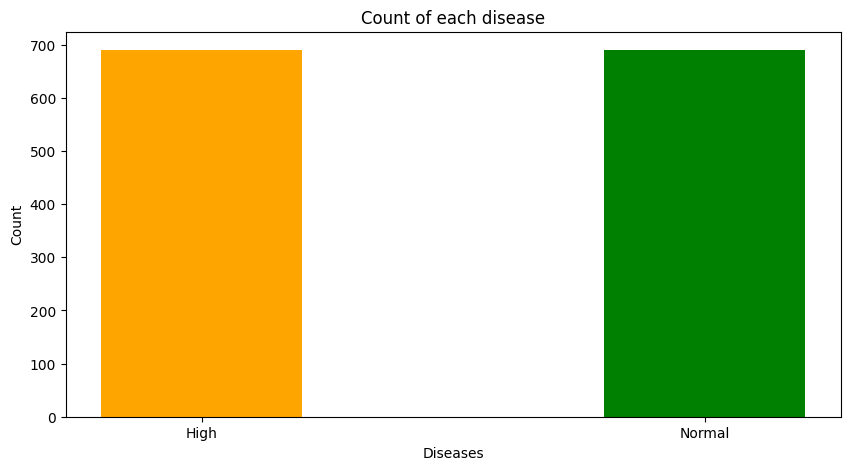

{'High': 690, 'Normal': 690}


In [ ]:
unique, counts = np.unique(res_y, return_counts=True)
data_count = dict(zip(unique, counts))

data = data_count

courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
        width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Count")
plt.title("Count of each disease")
plt.show()

print (data_count)

In [ ]:
res_y_data_encode = res_y.reshape(1380,1)
res_y_data_encode = np.where(res_y_data_encode == 'Normal',np.array([1,0]).reshape(1,2) , res_y_data_encode)
res_y_data_encode = np.where(res_y_data_encode == 'High',np.array([0,1]).reshape(1,2) , res_y_data_encode)

res_lables = res_y_data_encode.astype('float64')

In [ ]:
res_features = np.array(res_data)
res_lables = np.array(res_lables)

res_features.shape , res_lables.shape

((1380, 50), (1380, 2))

In [ ]:
x_train, x_val, y_train, y_val  = train_test_split(res_features,res_lables, test_size=0.175, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)


print (x_train.shape, x_val.shape, x_test.shape)
print (y_train.shape, y_val.shape, y_test.shape)

(1052, 50) (242, 50) (86, 50)
(1052, 2) (242, 2) (86, 2)


In [ ]:
x_train_gru = np.expand_dims(x_train,axis=1)
x_val_gru = np.expand_dims(x_val,axis=1)
x_test_gru = np.expand_dims(x_test,axis=1)

y_train_gru = np.expand_dims(y_train,axis=1)
y_val_gru = np.expand_dims(y_val,axis=1)
y_test_gru = np.expand_dims(y_test,axis=1)

In [ ]:
Input_Sample = Input(shape=(1,50))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_add_1 = add([model_3,model_2])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dropout(0.2)(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dropout(0.2)(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)
model_10 = Dropout(0.5)(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)
model_10 = Dropout(0.3)(model_10)

model_10 = Dense(2, activation="softmax")(model_10)

GRU_model = Model(inputs=Input_Sample, outputs = model_10)

GRU_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 50)]              0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 1, 256)               64256     ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 1, 256)               0         ['conv1d_3[0][0]']            
 g1D)                                                                                             
                                                                                                  
 batch_normalization_3 (Bat  (None, 1, 256)               1024      ['max_pooling1d_3[0][0]'] 

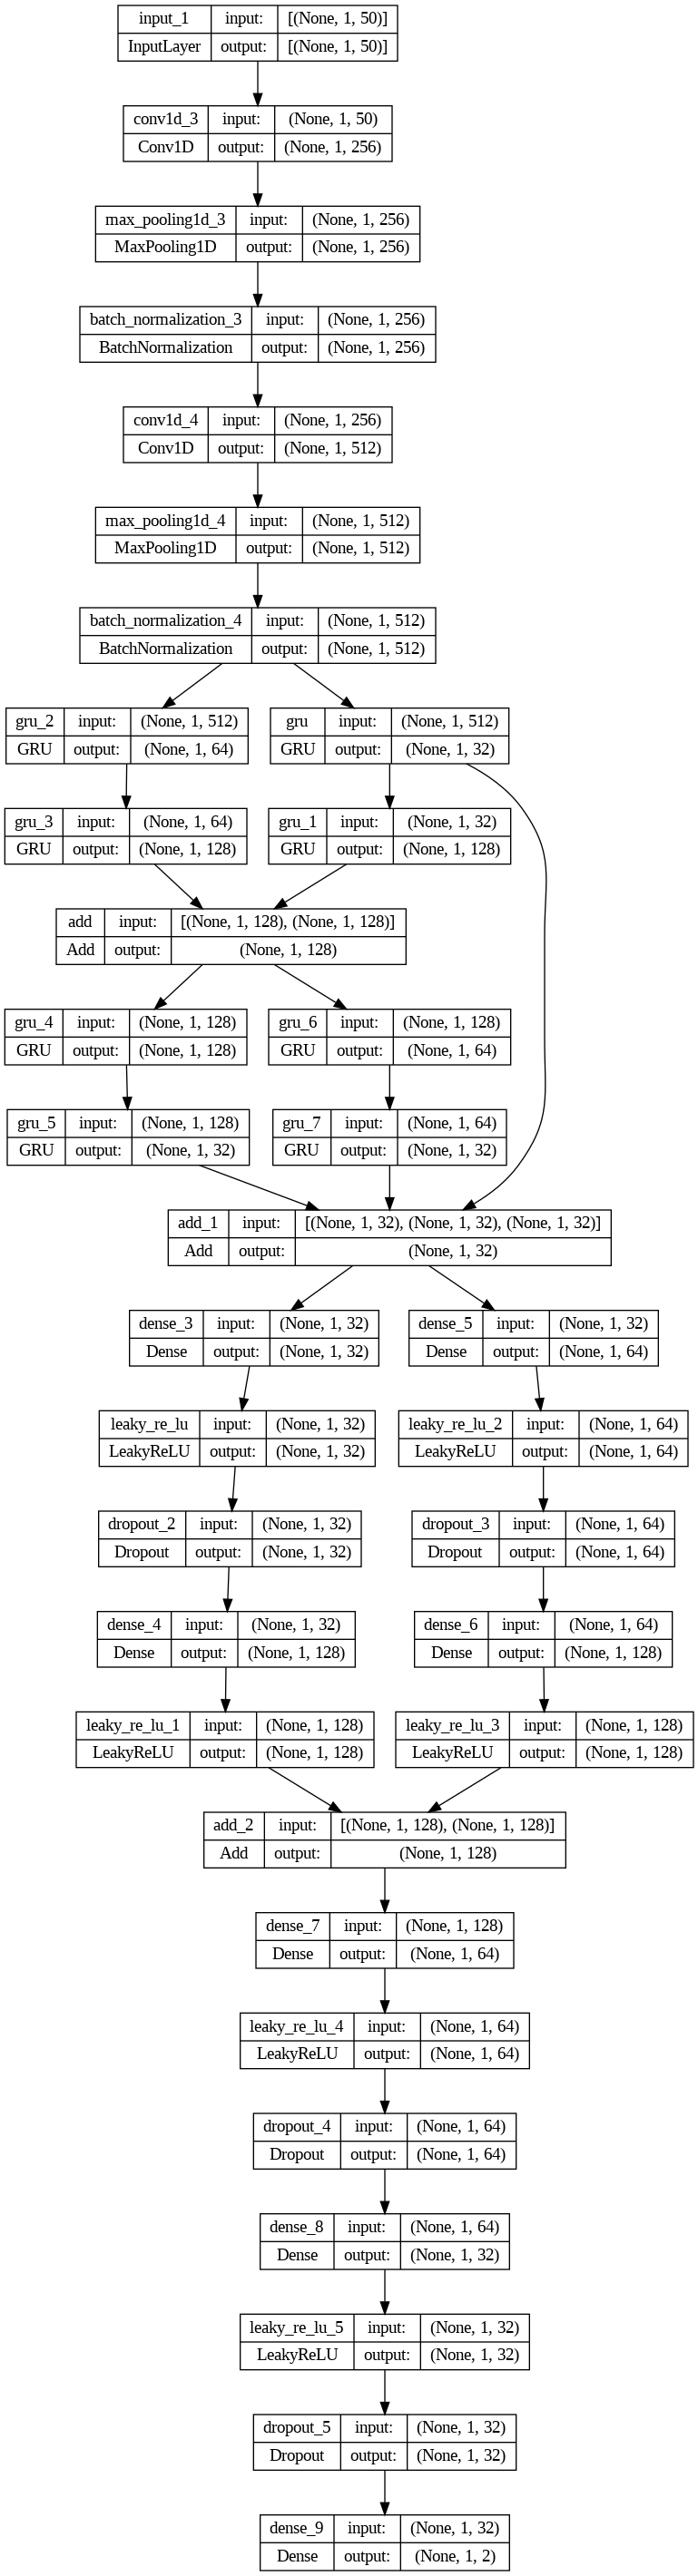

In [ ]:
tf.keras.utils.plot_model(GRU_model, "GRU.png", show_shapes=True)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
GRU_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("rr_GRU_CNN_1.h5",save_best_only=True)]

In [ ]:
history = GRU_model.fit(x_train_gru, y_train_gru, batch_size=16, epochs=250, validation_data=(x_val_gru, y_val_gru),callbacks = cb )

Epoch 1/250
66/66 [==============================] - 36s 92ms/step - loss: 0.6504 - accuracy: 0.6036 - val_loss: 0.6788 - val_accuracy: 0.5785
Epoch 2/250
 1/66 [..............................] - ETA: 1s - loss: 0.7124 - accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 2s 25ms/step - loss: 0.5764 - accuracy: 0.6882 - val_loss: 0.6442 - val_accuracy: 0.6198
Epoch 3/250
66/66 [==============================] - 2s 25ms/step - loss: 0.5454 - accuracy: 0.7253 - val_loss: 0.5616 - val_accuracy: 0.7521
Epoch 4/250
66/66 [==============================] - 2s 24ms/step - loss: 0.5096 - accuracy: 0.7605 - val_loss: 0.4789 - val_accuracy: 0.7893
Epoch 5/250
66/66 [==============================] - 2s 25ms/step - loss: 0.4744 - accuracy: 0.7747 - val_loss: 0.4709 - val_accuracy: 0.7562
Epoch 6/250
66/66 [==============================] - 2s 25ms/step - loss: 0.4793 - accuracy: 0.7747 - val_loss: 0.4056 - val_accuracy: 0.8388
Epoch 7/250
66/66 [==============================] - 2s 30ms/step - loss: 0.4390 - accuracy: 0.7956 - val_loss: 0.3958 - val_accuracy: 0.8347
Epoch 8/250
66/66 [==============================] - 2s 37ms/step - loss: 0.4192 - accuracy: 0.8137 - val_loss: 0.3950 - val_accuracy: 0.8099
Epoch 9/250
66/66 

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    :param history: TensorFlow/Keras History object returned by the fit method of models.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(8, 8))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    if 'accuracy' in history.history:
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

        plt.figure(figsize=(8, 8))
        plt.plot(epochs, accuracy, label='Training Accuracy')
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

8/8 [==============================] - 0s 21ms/step - loss: 0.1334 - accuracy: 0.9504


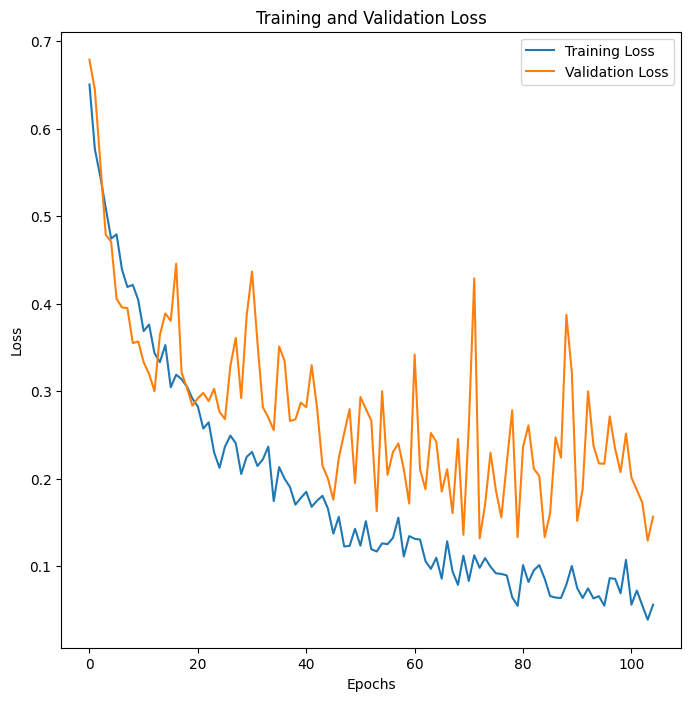

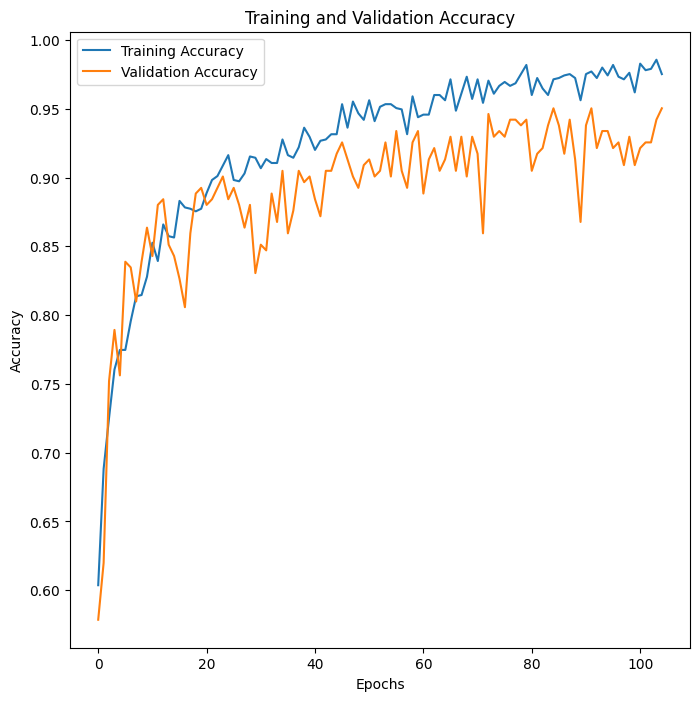

In [ ]:
GRU_model.evaluate(x_val_gru, y_val_gru)
plot_loss_curves(history)

3/3 [==============================] - 3s 37ms/step


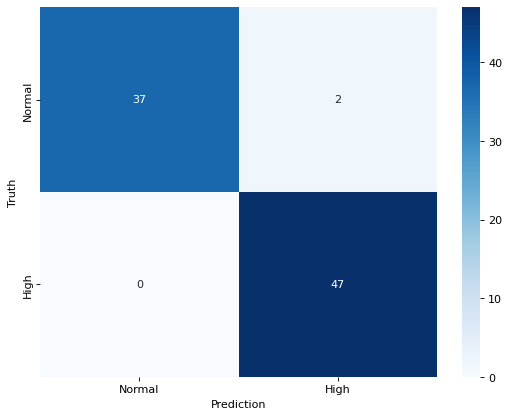

In [ ]:
classes = ["Normal", "High"]

preds = GRU_model.predict(x_test_gru)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97        39
        High       0.96      1.00      0.98        47

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.98        86
weighted avg       0.98      0.98      0.98        86



In [ ]:
def respiratory_rate_prediction_gru(audio_path):

    classes = ["Normal", "High"]

    data_x, sampling_rate = librosa.load(audio_path)


    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T,axis = 0)

    features = features.reshape(1,50)


    test_pred = GRU_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds, confidence)

In [ ]:
respiratory_rate_prediction_gru('/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav')

1/1 [==============================] - 0s 98ms/step
High 0.99743855
